# Modelling

## 1. Data preparation

### 1.1 Read the data

In [4]:
import pandas as pd
df=pd.read_csv('train_data_with_class_labels.csv')
df.head()

,image_path,product_id,category_id,category_level3,category_level2,category_level1
0,train_images/0_1000010653.png,0,1000010653,Telephone Case - Bumper Telephone,Telephone accessory,Telephony - GPS
1,train_images/7_1000004079.png,7,1000004079,Charger - AC Adapter - Cigarette Lighter - Solar,Connectivity - Food,COMPUTER SCIENCE
2,train_images/9_1000018290.png,9,1000018290,Classical music CD,CD,MUSIC
3,train_images/15_1000015309.png,15,1000015309,Other books,Other books,LIBRARY
4,train_images/19_1000014287.png,19,1000014287,SOCIOLOGY,SOCIAL SCIENCE,LIBRARY


In [5]:
df.shape

(999999, 6)

### 1.2 Removing the class labels with only 1 image

In [6]:
#first group the data points wrt to their class labels of level 3
count_df=df.groupby(['category_level3']).count()

#sort them for our interpretation
sorted_counts=count_df['product_id'].sort_values(ascending=False)
sorted_counts

category_level3
CD Pop Rock - CD Rock India        11183
Toner - Toner Recovery             10004
PRINTER CARTRIDGE                   9961
Other books                         9392
FRENCH LITERATURE                   9126
                                   ...  
Pilot pants                            1
Aluminum Sheet for Chicha              1
Articulation - Shoulder - Knees        1
WASTE COMPACTOR                        1
Toast holder                           1
Name: product_id, Length: 5186, dtype: int64

In [7]:
#get the names of the classes with 1 image
one_image_products=[]
sum=0
for j,row in enumerate(sorted_counts):
    if row==1:
        sum+=1
        one_image_products.append(sorted_counts.index[j])
        
print('number of classes of level 3 with single image are :',sum)

number of classes of level 3 with single image are : 116


In [8]:
# pick only those data points that do not belong to the one image classes.
from tqdm import tqdm
df_2=df
for cat in tqdm(one_image_products):
    df_2=df_2[df_2['category_level3'] != cat]
    
print(df_2.shape)

100%|██████████| 116/116 [00:12<00:00,  9.38it/s]

(999883, 6)


In [9]:
#print the total number of classes after removing the 1 image classes
count_df_2=df_2.groupby(['category_level3']).count()
print("number of classes before removing the 1 image classes = ",count_df.shape[0])
print("number of classes after removing the 1 image classes = ", count_df_2.shape[0])

#print the total number of data points after removing the data points belonging to 1 image classes
print('number of data points before removing the 1 image classes = ', df.shape[0])
print('number of data points after removing the 1 image classes = ',df_2.shape[0])

number of classes before removing the 1 image classes =  5186
number of classes after removing the 1 image classes =  5070
number of data points before removing the 1 image classes =  999999
number of data points after removing the 1 image classes =  999883


## 2. Data generators for training the models

In [10]:
import tensorflow as tf
import numpy as np

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.1)

#We are fitting the data to train data generator.
train_data_generator = data_gen.flow_from_dataframe( dataframe=df_2,directory='',x_col='image_path',y_col='category_level3',classes=list(count_df_2.index)\
                                                    ,target_size=(180,180),subset='training',shuffle=True,seed=10,batch_size=16,class_mode='categorical')

#We are fitting the data to validation data generator.
validation_data_generator = data_gen.flow_from_dataframe(dataframe=df_2,directory='',x_col='image_path',y_col='category_level3',classes=list(count_df_2.index)\
                                                       ,target_size=(180,180),subset='validation',shuffle=True,seed=10,batch_size=16,class_mode='categorical')


Found 899895 validated image filenames belonging to 5070 classes.
Found 99988 validated image filenames belonging to 5070 classes.


## 3. Models

### <b> 3.1 Simple Baseline model

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPool2D
import keras

input_layer = Input(shape=(180, 180, 3,))
conv_1= Conv2D(10, (3,3), activation='relu')(input_layer)
conv_2= Conv2D(13, 3, activation='relu', padding='same')(conv_1)
conv_3= Conv2D(14, 3, activation='relu', padding='same')(conv_2)

max_1=MaxPool2D(pool_size=(2,2),strides=2)(conv_3)
conv_4= Conv2D(20, 3, activation='relu', padding='same')(max_1)
max_1=MaxPool2D(pool_size=(2,2),strides=2)(conv_4)
conv_5= Conv2D(10, 3, activation='relu')(max_1)

flat_1= Flatten()(conv_5)
output_layer = Dense(5070,activation='softmax')(flat_1)

model=Model(inputs=[input_layer], outputs=[output_layer])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 13)      1183      
                                                                 
 conv2d_2 (Conv2D)           (None, 178, 178, 14)      1652      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 14)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 89, 89, 20)        2540      
                                                             

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

#compile the model with required optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Add the required call backs
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_accuracy",mode="auto",patience=2)
checkpt = ModelCheckpoint(monitor="val_accuracy",mode="auto",filepath='baseline_model.hdf5',save_best_only=True)
callback_list = [earlystop,checkpt,tensorboard_callback]

#give the number of train and test data points to be loaded in each batch
train_steps=train_data_generator.n//train_data_generator.batch_size
validation_steps=validation_data_generator.n//validation_data_generator.batch_size

#train the model and save the best model
model.fit_generator(train_data_generator, epochs=10, validation_data = validation_data_generator,\
                        steps_per_epoch=train_steps,validation_steps=validation_steps,callbacks=callback_list)

Epoch 1/10
28121/28121 [==============================] - 4418s 157ms/step - loss: 4.8219 - accuracy: 0.2959 - val_loss: 3.8629 - val_accuracy: 0.4072
Epoch 2/10
28121/28121 [==============================] - 4006s 142ms/step - loss: 3.2578 - accuracy: 0.4344 - val_loss: 3.8857 - val_accuracy: 0.4432
Epoch 3/10
28121/28121 [==============================] - 4273s 152ms/step - loss: 2.3713 - accuracy: 0.5433 - val_loss: 4.0741 - val_accuracy: 0.4482
Epoch 4/10
28121/28121 [==============================] - 4482s 159ms/step - loss: 1.8281 - accuracy: 0.6239 - val_loss: 4.4440 - val_accuracy: 0.4474
Epoch 5/10
28121/28121 [==============================] - 4497s 160ms/step - loss: 1.4800 - accuracy: 0.6808 - val_loss: 4.4685 - val_accuracy: 0.4465


In [9]:
# load the best model that we have saved

from keras.models import load_model

best_model= load_model('baseline_model.hdf5')

validation_steps=validation_data_generator.n//validation_data_generator.batch_size

score = best_model.evaluate_generator(generator=validation_data_generator, steps=validation_steps)
print("%s: %.2f%%" % (best_model.metrics_names[1], score[1]*100))

C:\Users\OVER_L~1\AppData\Local\Temp/ipykernel_26084/2812466112.py:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = best_model.evaluate_generator(generator=validation_data_generator, steps=validation_steps)


accuracy: 44.82%


In [ ]:
%tensorboard --logdir logs/fits

* The Blue line --> Train score and loss <br>
* The Red line --> Validation score and loss <br>

<img src='https://imgur.com/24vYlsF.png'>

### Observations
* Here we see that the simple base line model with 5 convolutional layers and a dense layer at the end , has achieved an accuracy of 44%, so , we can experiment with class weights , to see how the model learns with class weights as shown below.

### <b> 3.2 Simple base line model with class weights

In [16]:
# Compute the class weights:
import numpy as np
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

#convert the strings to numerical 
enc= LabelEncoder()
num_classes=enc.fit_transform(df_2['category_level3'].values)

#get the class names
classes= np.unique(num_classes)

#get the weights of the classes
class_weights= class_weight.compute_class_weight('balanced',classes=classes,y=num_classes)

#make a dictionary with class names and weights
class_weight_dict=dict(zip(classes,class_weights))

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

#compile the model with required optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Add the required call backs
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_accuracy",mode="auto",patience=2)
checkpt = ModelCheckpoint(monitor="val_accuracy",mode="auto",filepath='baseline_model_with_weights.hdf5',save_best_only=True)
callback_list = [earlystop,checkpt,tensorboard_callback]

#give the number of train and test data points to be loaded in each batch
train_steps=train_data_generator.n//train_data_generator.batch_size
validation_steps=validation_data_generator.n//validation_data_generator.batch_size

#train the model with class weights and save the best model
model.fit_generator(train_data_generator, epochs=10, validation_data = validation_data_generator,\
                        steps_per_epoch=train_steps,validation_steps=validation_steps,callbacks=callback_list, class_weight=class_weight_dict)

Epoch 1/10
28121/28121 [==============================] - 4696s 167ms/step - loss: 9.1428 - accuracy: 7.5567e-05 - val_loss: 8.4398 - val_accuracy: 0.0000e+00
Epoch 2/10
28121/28121 [==============================] - 4575s 163ms/step - loss: 9.2533 - accuracy: 2.1114e-05 - val_loss: 8.4515 - val_accuracy: 0.0000e+00
Epoch 3/10
28121/28121 [==============================] - 4852s 173ms/step - loss: 9.2920 - accuracy: 1.8892e-05 - val_loss: 8.4517 - val_accuracy: 0.0000e+00


### Observations
* Here we have the class weights proprotional to the inverse of the number of data points belonging to a particular class, and we see that the model is not able to learn much from the data, this is mainly due to the lack of more images for the minority classes desspite having more class weights. So , it is better to not assign any class weights.
* Here the goal is to classify as many images corrctly as possible, and the class with more images are generally the most important classes categories for bussiness since they are in large number and the sales also would be huge foe this category. So, there is no reason to heavily stress on the minority classes which are not that useful for the bussiness sales.

### <b> 3.3 Fine tuning the resnet50 model pretrained on the imagenet dataset

94781440/94765736 [==============================] - 59s 1us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 custom_conv2d (Conv2D)      (None, 6, 6, 512)         1049088   
                                                                 
 custom_flat (Flatten)       (None, 18432)             0         
                                                                 
 output (Dense)              (None, 5070)              93455310  
                                                                 
Total params: 118,092,110
Trainable params: 94,504,398
Non-trainable params: 23,587,712
_________________________________________________________________


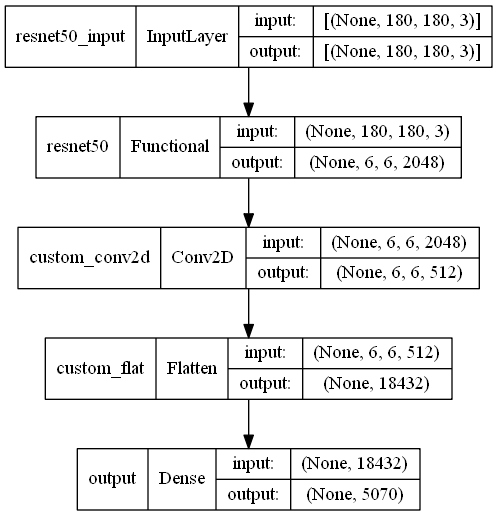

In [10]:
from tensorflow.keras import applications
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPool2D
import keras

model=Sequential()

#add the resnet34 to the model
model.add(applications.resnet.ResNet50(weights='imagenet',include_top = False, input_shape=(180,180,3)))
model.layers[0].trainable=False   #freeze all the layers of the resnet50 model

#add the custom layers as mentioned above
model.add(Conv2D(kernel_size=(1,1),filters=512,activation='relu', name='custom_conv2d'))
model.add(Flatten(name='custom_flat'))
model.add(Dense(5070,activation='softmax',name='output'))

model.summary()

#save the model image and plot the model
dot_img_file = 'resnet50.png'
keras.utils.vis_utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

#compile the model with required optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Add the required call backs
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_accuracy",verbose=1,mode="auto",patience=2)
checkpt = ModelCheckpoint(monitor="val_accuracy",mode="auto",verbose=1,filepath='resnet50_model.hdf5',save_best_only=True)
callback_list = [earlystop,checkpt,tensorboard_callback]

#give the number of train and test data points to be loaded in each batch
train_steps=train_data_generator.n//train_data_generator.batch_size
validation_steps=validation_data_generator.n//validation_data_generator.batch_size

#train the model and save the best model
model.fit_generator(train_data_generator, epochs=10, validation_data = validation_data_generator,\
                        steps_per_epoch=train_steps,validation_steps=validation_steps,callbacks=callback_list)

Epoch 1/10
28121/28121 [==============================] - ETA: 0s - loss: 5.5600 - accuracy: 0.1819
Epoch 00001: val_accuracy improved from -inf to 0.25926, saving model to baseline_model.hdf5
28121/28121 [==============================] - 5345s 190ms/step - loss: 5.5600 - accuracy: 0.1819 - val_loss: 4.8494 - val_accuracy: 0.2593
Epoch 2/10
28121/28121 [==============================] - ETA: 0s - loss: 5.1621 - accuracy: 0.2172
Epoch 00002: val_accuracy improved from 0.25926 to 0.26169, saving model to baseline_model.hdf5
28121/28121 [==============================] - 5144s 183ms/step - loss: 5.1621 - accuracy: 0.2172 - val_loss: 4.8954 - val_accuracy: 0.2617
Epoch 3/10
28121/28121 [==============================] - ETA: 0s - loss: 5.1414 - accuracy: 0.2207
Epoch 00003: val_accuracy did not improve from 0.26169
28121/28121 [==============================] - 4668s 166ms/step - loss: 5.1414 - accuracy: 0.2207 - val_loss: 4.9997 - val_accuracy: 0.2560
Epoch 4/10
28121/28121 [============

In [ ]:
%tensorboard --logdir logs/fits

* The Green line --> Train score and loss <br>
* The White line --> Validation score and loss <br>

<img src='https://imgur.com/ICzT0pl.png'>

### Observations

* Here we have taken the pretrained resnet50 model by freezing the weights of the imported model and then added our custom convolutional layer and a dense layer and trained the additional layer only.
* Here we see that the accuracy is not improving and not overfitting also , which means that we need to make more layers trainable and increase the fully connected layers at the end so that , the model learns effectively.
* This may be mainly due to the dataset which is with us because in the EDA we have seen that the images contain a variety of different backgrounds and the labels are also quite different from the imagenet because of the ecommerce domain.
* We need to keep the learning rate schedule with very low learning rate , so that the initialized weights are not changed drastically.

### <b>3.4 Resnet50 with fine tuning all the layers with very low learning rate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 custom_conv2d (Conv2D)      (None, 6, 6, 512)         1049088   
                                                                 
 custom_flat (Flatten)       (None, 18432)             0         
                                                                 
 custom_FC (Dense)           (None, 5070)              93455310  
                                                                 
 output_layer (Dense)        (None, 5070)              25709970  
                                                                 
Total params: 143,802,080
Trainable params: 143,748,960
Non-trainable params: 53,120
_________________________________________________________________


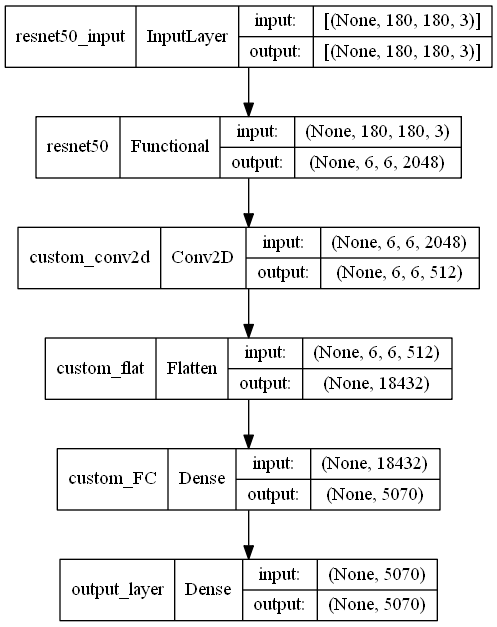

In [8]:
from tensorflow.keras import applications
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPool2D
import keras

model=Sequential()
#get the resnet50 with pretrained weights
resnet_model=applications.resnet.ResNet50(weights='imagenet',include_top = False, input_shape=(180,180,3))
model.add(resnet_model)
#add a custom convolutional layer
model.add(Conv2D(kernel_size=(1,1),filters=512,activation='relu', name='custom_conv2d'))
#flatten the output from the convolutional layer
model.add(Flatten(name='custom_flat'))
#add a fully connected layer
model.add(Dense(5070,activation='relu',name='custom_FC'))
#add an output layer with softmax
model.add(Dense(5070, activation='softmax', name='output_layer'))
#make the model as shown below
model.summary()

#plot the final architecture of the model
dot_img_file = 'resnet_model_all_layers_tunned.png'
keras.utils.vis_utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,LearningRateScheduler
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

#assign the custom learning rate
def scheduler(epoch,lr):
    if epoch > 7:
        lr = 0.0001
    if epoch > 9:
        lr = 0.00005
    if epoch > 11:
        lr = 0.00001
    return lr
lr_schedule=LearningRateScheduler(scheduler)

#compile the model with required optimizer
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),metrics=['accuracy'])

#Add the required call backs
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_accuracy",verbose=1,mode="auto",patience=2)
checkpt = ModelCheckpoint(monitor="val_accuracy",mode="auto",verbose=1,filepath='resnet50_model_full_tuning.hdf5',save_best_only=True)
callback_list = [earlystop,checkpt,tensorboard_callback,lr_schedule]

#give the number of train and test data points to be loaded in each batch
train_steps=train_data_generator.n//train_data_generator.batch_size
validation_steps=validation_data_generator.n//validation_data_generator.batch_size

#train the model and save the best model
model.fit_generator(train_data_generator, epochs=10, validation_data = validation_data_generator,\
                        steps_per_epoch=train_steps,validation_steps=validation_steps,callbacks=callback_list)

Epoch 1/10
56243/56243 [==============================] - ETA: 0s - loss: 4.4569 - accuracy: 0.3151
Epoch 00001: val_accuracy improved from -inf to 0.38921, saving model to resnet50_model_full_tuning.hdf5
56243/56243 [==============================] - 12900s 229ms/step - loss: 4.4569 - accuracy: 0.3151 - val_loss: 3.9261 - val_accuracy: 0.3892 - lr: 3.0000e-04
Epoch 2/10
56243/56243 [==============================] - ETA: 0s - loss: 3.6525 - accuracy: 0.4003
Epoch 00002: val_accuracy improved from 0.38921 to 0.47811, saving model to resnet50_model_full_tuning.hdf5
56243/56243 [==============================] - 14491s 258ms/step - loss: 3.6525 - accuracy: 0.4003 - val_loss: 3.1421 - val_accuracy: 0.4781 - lr: 3.0000e-04
Epoch 3/10
56243/56243 [==============================] - ETA: 0s - loss: 3.3065 - accuracy: 0.4386
Epoch 00003: val_accuracy improved from 0.47811 to 0.50364, saving model to resnet50_model_full_tuning.hdf5
56243/56243 [==============================] - 15666s 279ms/ste

In [13]:
# load the best model that we have saved

from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

best_model= load_model('resnet50_model_full_tuning.hdf5')

validation_steps=validation_data_generator.n//validation_data_generator.batch_size

score = best_model.evaluate_generator(generator=validation_data_generator, steps=validation_steps)
print("%s: %.2f%%" % (best_model.metrics_names[1], score[1]*100))

accuracy: 54.90%


In [ ]:
%tensorboard --logdir logs/fits

* The Red line --> Train score and loss <br>
* The Blue line --> Validation score and loss <br>

<img src='https://imgur.com/oYqJw4C.png'>

### Observations
* Here we can see that the score has definetely improved when we tune all the layers instead of last layers , which shows that the image dataset that we have is not very similar to imagenet but is having a slightly different features as we have seen in the exploratory data analysis. 
* Here we can see that the model has achieved and validation accuracy of 54% which is not that great and is not able to get a good score inspite of fine tuning all the layers, this means that we need to give it more data, so we can try with image augmentations but it will take up still more resources and time than the model above considering the fact that the above model itself took 46 hrs of training.

## 4. Display the image with predicted class and actual class for interpretation

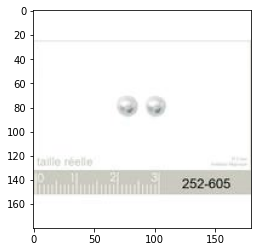

1/1 [==============================] - 4s 4s/step
actual_class_label : EARRING
predicted_class_label : ATTACH  with probability :  37.55035698413849 %
predicted_class_label : Table - Canvas  with probability :  10.433565080165863 %
predicted_class_label : Stickers - Adhesive Letters  with probability :  7.765940576791763 %
predicted_class_label : Wallpaper - Wall Cover (Fiberglass - Friesland - Adhesive Coating)  with probability :  5.034009367227554 %
************************************


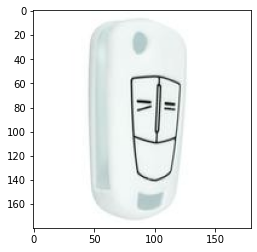

1/1 [==============================] - 0s 26ms/step
actual_class_label : Case - CLE COQUE - REMOTE CONTROL
predicted_class_label : ATTACH  with probability :  37.55035698413849 %
predicted_class_label : Table - Canvas  with probability :  10.433565080165863 %
predicted_class_label : Stickers - Adhesive Letters  with probability :  7.765940576791763 %
predicted_class_label : Wallpaper - Wall Cover (Fiberglass - Friesland - Adhesive Coating)  with probability :  5.034009367227554 %
************************************


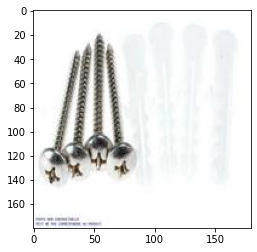

1/1 [==============================] - 0s 23ms/step
actual_class_label : Wash accessories - DRYING - PIECES WASHING-DRYING
predicted_class_label : ATTACH  with probability :  37.55035698413849 %
predicted_class_label : Table - Canvas  with probability :  10.433565080165863 %
predicted_class_label : Stickers - Adhesive Letters  with probability :  7.765940576791763 %
predicted_class_label : Wallpaper - Wall Cover (Fiberglass - Friesland - Adhesive Coating)  with probability :  5.034009367227554 %
************************************


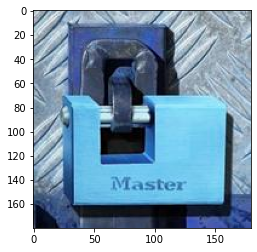

1/1 [==============================] - 0s 25ms/step
actual_class_label : Lock - Barrel - Cylinder - Padlock - Locks - Anti-Theft
predicted_class_label : ATTACH  with probability :  37.55035698413849 %
predicted_class_label : Table - Canvas  with probability :  10.433565080165863 %
predicted_class_label : Stickers - Adhesive Letters  with probability :  7.765940576791763 %
predicted_class_label : Wallpaper - Wall Cover (Fiberglass - Friesland - Adhesive Coating)  with probability :  5.034009367227554 %
************************************


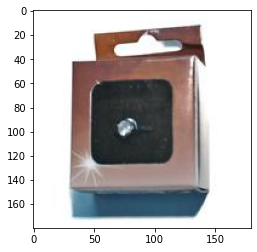

1/1 [==============================] - 0s 22ms/step
actual_class_label : Ring - ring
predicted_class_label : ATTACH  with probability :  37.55035698413849 %
predicted_class_label : Table - Canvas  with probability :  10.433565080165863 %
predicted_class_label : Stickers - Adhesive Letters  with probability :  7.765940576791763 %
predicted_class_label : Wallpaper - Wall Cover (Fiberglass - Friesland - Adhesive Coating)  with probability :  5.034009367227554 %
************************************


In [11]:
import matplotlib.pyplot as plt
import cv2
import random
from keras.models import load_model
import numpy as np

model=load_model('resnet50_model_full_tuning.hdf5')

images_ = df_2['image_path'].values
classes_ = df_2['category_level3'].values
lst=np.arange(len(images_))
ids=np.random.choice(lst, size = 5, replace = False)

for i in ids:
  image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (180, 180))
  image = np.expand_dims(image, axis=0)
  
  plt.imshow(cv2.imread(images_[i]))
  plt.show()
  
  pred = model.predict(image,verbose=1)
  
  actual_label=classes_[i]
  print('actual_class_label :',actual_label)
  
  for h in range(4):
    pred_index=np.argsort(pred[0])[-1-h]
    predicted_label=count_df_2.index[pred_index]
    print('predicted_class_label :',predicted_label, ' with probability : ', pred[0][pred_index]*100,'%')
  
  print("************************************")
  

# 5. New approach

## 5.1 Data sampling

### Read the data

In [1]:
import pandas as pd
df=pd.read_csv('train_data_with_class_labels.csv')
df.head()

,image_path,product_id,category_id,category_level3,category_level2,category_level1
0,train_images/0_1000010653.png,0,1000010653,Telephone Case - Bumper Telephone,Telephone accessory,Telephony - GPS
1,train_images/7_1000004079.png,7,1000004079,Charger - AC Adapter - Cigarette Lighter - Solar,Connectivity - Food,COMPUTER SCIENCE
2,train_images/9_1000018290.png,9,1000018290,Classical music CD,CD,MUSIC
3,train_images/15_1000015309.png,15,1000015309,Other books,Other books,LIBRARY
4,train_images/19_1000014287.png,19,1000014287,SOCIOLOGY,SOCIAL SCIENCE,LIBRARY


### Group the data points by the category level 2 

In [2]:
#first group the data points wrt to their class labels of level 2
count_df=df.groupby(['category_level2']).count()

#sort them for our interpretation
sorted_counts=count_df['product_id'].sort_values(ascending=False)
sorted_counts

category_level2
ROOMS                               74222
Telephone accessory                 69798
CD                                  51700
JEWELRY                             36619
Connectivity - Food                 25547
                                    ...  
Tools of the beekeeper                  1
Dog sport                               1
LNPR - new book at reduced price        1
ICE                                     1
PIERCING                                1
Name: product_id, Length: 481, dtype: int64

### Let us see how many classes will be present if we remove the classes by keeping number of images as threshold

In [18]:
#get the names of the classes with less than some number of images

class_groups={}
numbers=[2,10,30,50,100,200,300,400,500,1000,5000,10000,20000,50000,80000]
for i in numbers:
    sum=0
    class_names=[]
    for j,row in enumerate(sorted_counts):
        if row<i:
            sum+=1
            class_names.append(sorted_counts.index[j])
    class_groups[i]=class_names
            
    print('number of classes of level 2 with less than ',i,' images are :',sum)


number of classes of level 2 with less than  2  images are : 6
number of classes of level 2 with less than  10  images are : 32
number of classes of level 2 with less than  30  images are : 58
number of classes of level 2 with less than  50  images are : 83
number of classes of level 2 with less than  100  images are : 122
number of classes of level 2 with less than  200  images are : 171
number of classes of level 2 with less than  300  images are : 200
number of classes of level 2 with less than  400  images are : 223
number of classes of level 2 with less than  500  images are : 246
number of classes of level 2 with less than  1000  images are : 303
number of classes of level 2 with less than  5000  images are : 436
number of classes of level 2 with less than  10000  images are : 465
number of classes of level 2 with less than  20000  images are : 473
number of classes of level 2 with less than  50000  images are : 478
number of classes of level 2 with less than  80000  images are :

### Let us see how much percentage of the data will be remaining if we remove the above printed classes

In [23]:
from tqdm import tqdm

df_2=df
total=df_2.shape[0]
for i in tqdm(numbers):
    for cat in class_groups.get(i):
        df_2=df_2[df_2['category_level2'] != cat]
    remaining=df_2.shape[0]
    print('number of data points remaining after we remove the classes with less than ',i,' images are ',remaining,' which is ',remaining*100/total,'%')
    


  7%|▋         | 1/15 [00:00<00:08,  1.61it/s]

number of data points remaining after we remove the classes with less than  2  images are  999993  which is  99.9993999994 %


 13%|█▎        | 2/15 [00:04<00:29,  2.30s/it]

number of data points remaining after we remove the classes with less than  10  images are  999843  which is  99.98439998439999 %


 20%|██        | 3/15 [00:10<00:49,  4.16s/it]

number of data points remaining after we remove the classes with less than  30  images are  999359  which is  99.93599993599993 %


 27%|██▋       | 4/15 [00:19<01:06,  6.07s/it]

number of data points remaining after we remove the classes with less than  50  images are  998372  which is  99.83729983729984 %


 33%|███▎      | 5/15 [00:32<01:25,  8.58s/it]

number of data points remaining after we remove the classes with less than  100  images are  995672  which is  99.56729956729957 %


 40%|████      | 6/15 [00:50<01:46, 11.81s/it]

number of data points remaining after we remove the classes with less than  200  images are  988457  which is  98.84579884579884 %


 47%|████▋     | 7/15 [01:11<01:58, 14.79s/it]

number of data points remaining after we remove the classes with less than  300  images are  981523  which is  98.15239815239815 %


 53%|█████▎    | 8/15 [01:34<02:02, 17.52s/it]

number of data points remaining after we remove the classes with less than  400  images are  973390  which is  97.33909733909734 %


 60%|██████    | 9/15 [02:00<01:59, 19.99s/it]

number of data points remaining after we remove the classes with less than  500  images are  963228  which is  96.32289632289633 %


 67%|██████▋   | 10/15 [02:30<01:55, 23.14s/it]

number of data points remaining after we remove the classes with less than  1000  images are  923536  which is  92.35369235369235 %


 73%|███████▎  | 11/15 [03:02<01:43, 25.88s/it]

number of data points remaining after we remove the classes with less than  5000  images are  622543  which is  62.254362254362256 %


 80%|████████  | 12/15 [03:25<01:15, 25.04s/it]

number of data points remaining after we remove the classes with less than  10000  images are  426780  which is  42.67804267804268 %


 87%|████████▋ | 13/15 [03:43<00:45, 22.91s/it]

number of data points remaining after we remove the classes with less than  20000  images are  325018  which is  32.5018325018325 %


100%|██████████| 15/15 [03:55<00:00, 15.67s/it]

number of data points remaining after we remove the classes with less than  50000  images are  195720  which is  19.57201957201957 %
number of data points remaining after we remove the classes with less than  80000  images are  0  which is  0.0 %


### Observations
* Here even after we remove the classes with less than 1000 images , we will have left with approx 90% of the data which means that 90% of the objects in the ecommerce websites belong to the classes with more than 500 images which is what matters and we do not have to bother about the minority classes because they do not bring much business value.
* Also for the majority classes ,we have excessive images covering a wide variety of breadth which spreads the data too thin. So, we will cut down the number of images per class to 1000 and see how much data we are left with and check the performance of the model.
* Here we need to increase the depth of the data, which means that we need image augmentations through which the models sees the similar image multiple times and hence becomes strong unlike the original case where each image is not shown more than once which led to poor performance.
* Here we will try to improve the performance of the model while reducing the size of the dataset by increasing the density of the dataset.

### Now we will remove those data points which belong to the classes with less than 1000 images 

In [25]:
#get the names of the classes with less than 1000 images
class_names=[]
sum=0
for j,row in enumerate(sorted_counts):
    if row<1000:
        sum+=1
        class_names.append(sorted_counts.index[j])
        
print('number of classes of level 2 with less than 1000 image are :',sum)
print('remaining classes after remmoving the above classes = ',481-sum)

number of classes of level 2 with less than 1000 image are : 303
remaining classes after remmoving the above classes =  178


### So we will chose only 178 classes as they are comprising more than 90% of the data and are important 

In [27]:
# pick only those data points that do not belong to the classes with < 1000 images
from tqdm import tqdm
df_2=df
for cat in tqdm(class_names):
    df_2=df_2[df_2['category_level2'] != cat]
    
print(df_2.shape)

100%|██████████| 303/303 [00:31<00:00,  9.74it/s]

(923536, 6)


### Let us remove the excess images from each class, so that they are capped to 1000 only

In [28]:
#first group the data points wrt to their class labels of level 2
count_df_2=df_2.groupby(['category_level2']).count()

#sort them for our interpretation
sorted_counts_2=count_df_2['product_id'].sort_values(ascending=False)
sorted_counts_2

category_level2
ROOMS                            74222
Telephone accessory              69798
CD                               51700
JEWELRY                          36619
Connectivity - Food              25547
                                 ...  
Professional clothing             1024
SECURITY - PROTECTION SITE        1024
Cleaning - Liquid Maintenance     1023
FOOD                              1018
Imitation toy                     1013
Name: product_id, Length: 178, dtype: int64

In [58]:
#form a tuple of dataframes containing images of each class
data_frames_tuple=()

#loop through each class label to filter out required datapoints
for class_name in tqdm(sorted_counts_2.index):
    
    #after selecting the required datapoints, randomly sample 1000 datapoints from them 
    new_df=df_2[df_2['category_level2']==class_name].sample(n=1000)
    #add them to the tuple
    data_frames_tuple+=(new_df,)

#concat all the dataframes in the tuple to form a new dataframe with less images per class
new_small_df=pd.concat(data_frames_tuple)

print('shape of the new dataframe = ',new_small_df.shape)

new_small_df.head()


100%|██████████| 178/178 [00:06<00:00, 28.94it/s]


shape of the new dataframe =  (178000, 6)


,image_path,product_id,category_id,category_level3,category_level2,category_level1
293624,train_images/6867758_1000005842.png,6867758,1000005842,STARTER,ROOMS,AUTO MOTO
507326,train_images/11509797_1000009661.png,11509797,1000009661,Complete Wheel - Wheel with Rim,ROOMS,AUTO MOTO
983404,train_images/23185974_1000005850.png,23185974,1000005850,Brake discs,ROOMS,AUTO MOTO
351018,train_images/8083094_1000005910.png,8083094,1000005910,Body Kit - Cashier - Farm - Spoiler - Becquet ...,ROOMS,AUTO MOTO
440831,train_images/10026317_1000005986.png,10026317,1000005986,Protect Frame - Chain - Disc - Fork - Main - E...,ROOMS,AUTO MOTO


In [59]:
#save the dataframe to a csv file for later use
new_small_df.to_csv('small_data.csv',index=False)

### Here we are left with 178000 images with 178 classes and with 1000 images per class. If we perform image augmentation of 3 types, we will still have 178000*3 = 534000 images which is roughly 50% of the taken data

## 5.2 Data Preparation

### Read the saved small data frame

In [1]:
import pandas as pd

new_small_df=pd.read_csv('small_data.csv')
new_small_df.head()

,image_path,product_id,category_id,category_level3,category_level2,category_level1
0,train_images/6867758_1000005842.png,6867758,1000005842,STARTER,ROOMS,AUTO MOTO
1,train_images/11509797_1000009661.png,11509797,1000009661,Complete Wheel - Wheel with Rim,ROOMS,AUTO MOTO
2,train_images/23185974_1000005850.png,23185974,1000005850,Brake discs,ROOMS,AUTO MOTO
3,train_images/8083094_1000005910.png,8083094,1000005910,Body Kit - Cashier - Farm - Spoiler - Becquet ...,ROOMS,AUTO MOTO
4,train_images/10026317_1000005986.png,10026317,1000005986,Protect Frame - Chain - Disc - Fork - Main - E...,ROOMS,AUTO MOTO


### Train test split

In [2]:
from sklearn.model_selection import train_test_split

y=new_small_df['category_level2'] # this is just used to perform stratify splitting

#split the data
X_train,X_test,y_train,y_test=train_test_split(new_small_df,y,test_size=0.1,stratify=y)

print('number of data points in train dataset = ', X_train.shape[0])
print('number of data points in test dataset = ',X_test.shape[0])
print('number of classes in train data = ',X_train['category_level2'].value_counts().shape[0])
print('number of classes in train data = ',X_test['category_level2'].value_counts().shape[0])

number of data points in train dataset =  160200
number of data points in test dataset =  17800
number of classes in train data =  178
number of classes in train data =  178


### Data generators for training the models

In [3]:
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#prepare the list of class names
count_df=new_small_df.groupby(['category_level2']).count()
classes_list=list(count_df.index)

#perform augmentations for the train data
data_gen_1 = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,rotation_range=40,shear_range=0.3)

#We are fitting the data to train data generator.
train_data_generator = data_gen_1.flow_from_dataframe( dataframe=X_train,directory='',x_col='image_path',y_col='category_level2',classes=classes_list\
                                                    ,target_size=(128,128),shuffle=True,seed=10,batch_size=16,class_mode='categorical')

#do not perform augmentations for the test data
data_gen_2 = tf.keras.preprocessing.image.ImageDataGenerator()

#fit the test data to the test data generator
validation_data_generator = data_gen_2.flow_from_dataframe(dataframe=X_test,directory='',x_col='image_path',y_col='category_level2',classes=classes_list\
                                                    ,target_size=(128,128),shuffle=True,seed=10,batch_size=16,class_mode='categorical')


Found 160200 validated image filenames belonging to 178 classes.
Found 17800 validated image filenames belonging to 178 classes.


## 5.3 Models
### Let us first try with simple models and see the results and then go for more complex models

### 5.3.1 VGG-16 by freezing the pretrained layers and training only additional layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 custom_conv1d (Conv2D)      (None, 2, 2, 1024)        4719616   
                                                                 
 custom_pool (MaxPooling2D)  (None, 1, 1, 1024)        0         
                                                                 
 custom_flat (Flatten)       (None, 1024)              0         
                                                                 
 custom_fc1 (Dense)          (None, 1024)              1049600   
                                                                 
 custom_fc2 (Dense)          (None, 512)               524800    
                                                                 
 output (Dense)              (None, 178)               9

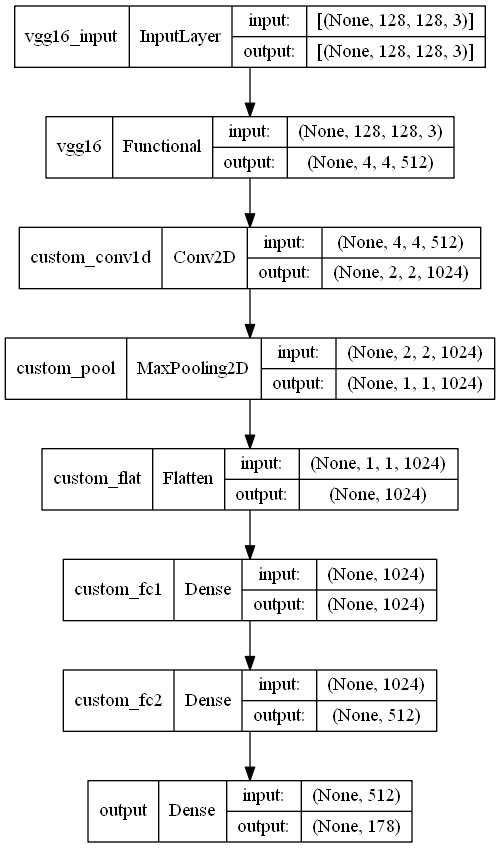

In [74]:
from tensorflow.keras import applications
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPool2D
import keras

model=Sequential()

#add the VGG-16 to the model
model.add(applications.vgg16.VGG16(weights='imagenet',include_top = False, input_shape=(128,128,3)))
model.layers[0].trainable=False   #freeze all the layers of the VGG-16

#add the custom layers as mentioned above
model.add(Conv2D(kernel_size=(3,3),filters=1024,activation='relu', name='custom_conv1d'))
model.add(MaxPool2D(pool_size=(2,2),strides=(1,1), name='custom_pool'))
model.add(Flatten(name='custom_flat'))
model.add(Dense(1024, activation='relu',name='custom_fc1'))
model.add(Dense(512,activation='relu',name='custom_fc2'))
model.add(Dense(178,activation='softmax',name='output'))

model.summary()

#save the model image and plot the model
dot_img_file = 'VGG_16_small_model.png'
keras.utils.vis_utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [75]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

#compile the model with required optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Add the required call backs
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_loss",mode="auto",patience=2,verbose=1)
checkpt = ModelCheckpoint(monitor="val_loss",mode="auto",filepath='VGG_16_small.hdf5',verbose=1,save_best_only=True)
callback_list = [earlystop,checkpt, tensorboard_callback]

#give the number of train and test data points to be loaded in each batch
train_steps=train_data_generator.n//train_data_generator.batch_size
validation_steps=validation_data_generator.n//validation_data_generator.batch_size

#train the model and save the best model
model.fit_generator(train_data_generator, epochs=10, validation_data = validation_data_generator,\
                        steps_per_epoch=train_steps,validation_steps=validation_steps,callbacks=callback_list)

Epoch 1/10
10012/10012 [==============================] - ETA: 0s - loss: 3.9354 - accuracy: 0.1547
Epoch 00001: val_loss improved from inf to 3.58136, saving model to VGG_16_small.hdf5
10012/10012 [==============================] - 1258s 125ms/step - loss: 3.9354 - accuracy: 0.1547 - val_loss: 3.5814 - val_accuracy: 0.2047
Epoch 2/10
10012/10012 [==============================] - ETA: 0s - loss: 3.5668 - accuracy: 0.2071
Epoch 00002: val_loss improved from 3.58136 to 3.49877, saving model to VGG_16_small.hdf5
10012/10012 [==============================] - 1144s 114ms/step - loss: 3.5668 - accuracy: 0.2071 - val_loss: 3.4988 - val_accuracy: 0.2204
Epoch 3/10
10012/10012 [==============================] - ETA: 0s - loss: 3.4679 - accuracy: 0.2263
Epoch 00003: val_loss improved from 3.49877 to 3.43310, saving model to VGG_16_small.hdf5
10012/10012 [==============================] - 1106s 111ms/step - loss: 3.4679 - accuracy: 0.2263 - val_loss: 3.4331 - val_accuracy: 0.2431
Epoch 4/10
100

In [ ]:
%tensorboard --logdir logs/fits

* The Pink line --> Train score and loss <br>
* The Green line --> Validation score and loss <br>

<img src='https://imgur.com/dBkVm1b.png'>

### 5.3.2 VGG-16 by tuning all the layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 custom_conv1d (Conv2D)      (None, 2, 2, 1024)        4719616   
                                                                 
 custom_pool (MaxPooling2D)  (None, 1, 1, 1024)        0         
                                                                 
 custom_flat (Flatten)       (None, 1024)              0         
                                                                 
 custom_fc1 (Dense)          (None, 1024)              1049600   
                                                                 
 custom_fc2 (Dense)          (None, 512)               524800    
                                                                 
 output (Dense)              (None, 178)               9

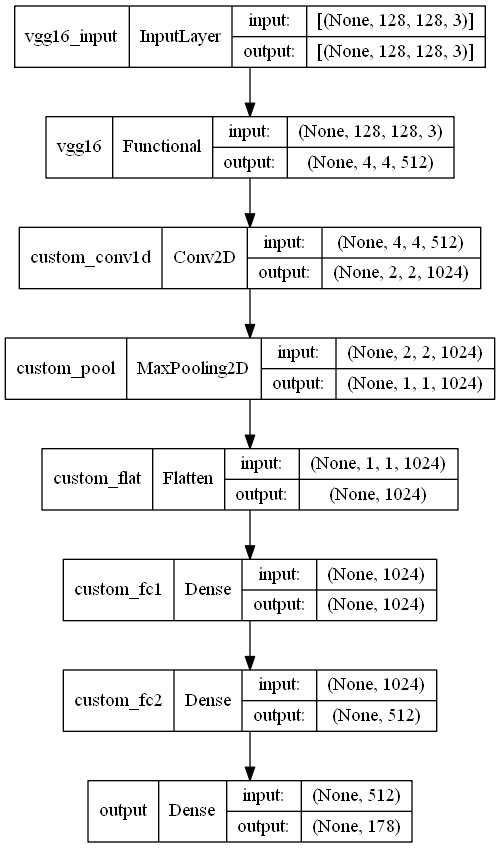

In [4]:
from tensorflow.keras import applications
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPool2D
import keras

model=Sequential()

#add the VGG-16 to the model
model.add(applications.vgg16.VGG16(weights='imagenet',include_top = False, input_shape=(128,128,3)))

#add the custom layers as mentioned above
model.add(Conv2D(kernel_size=(3,3),filters=1024,activation='relu', name='custom_conv1d'))
model.add(MaxPool2D(pool_size=(2,2),strides=(1,1), name='custom_pool'))
model.add(Flatten(name='custom_flat'))
model.add(Dense(1024, activation='relu',name='custom_fc1'))
model.add(Dense(512,activation='relu',name='custom_fc2'))
model.add(Dense(178,activation='softmax',name='output'))

model.summary()

#save the model image and plot the model
dot_img_file = 'VGG_16_small_model_full.png'
keras.utils.vis_utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,LearningRateScheduler
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

#assign the custom learning rate
def scheduler(epoch,lr):
    if epoch > 4:
        lr = 0.0005
    if epoch > 8:
        lr = 0.0001
    if epoch > 11:
        lr = 0.00005
    if epoch > 14:
        lr = 0.00001
    return lr
lr_schedule=LearningRateScheduler(scheduler)

#compile the model with required optimizer
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1), metrics=['accuracy'])

#Add the required call backs
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_accuracy",mode="auto",patience=2,verbose=1)
checkpt = ModelCheckpoint(monitor="val_accuracy",mode="auto",filepath='VGG_16_small_fully_tuned.hdf5',verbose=1,save_best_only=True)
callback_list = [earlystop,checkpt, tensorboard_callback, lr_schedule]

#give the number of train and test data points to be loaded in each batch
train_steps=train_data_generator.n//train_data_generator.batch_size
validation_steps=validation_data_generator.n//validation_data_generator.batch_size

#train the model and save the best model
model.fit_generator(train_data_generator, epochs=20, validation_data = validation_data_generator,\
                        steps_per_epoch=train_steps,validation_steps=validation_steps,callbacks=callback_list)

Epoch 1/20
10012/10012 [==============================] - ETA: 0s - loss: 2.4016 - accuracy: 0.4218
Epoch 00001: val_accuracy improved from -inf to 0.41592, saving model to VGG_16_small_fully_tuned.hdf5
10012/10012 [==============================] - 1810s 181ms/step - loss: 2.4016 - accuracy: 0.4218 - val_loss: 2.5098 - val_accuracy: 0.4159 - lr: 0.0010
Epoch 2/20
10012/10012 [==============================] - ETA: 0s - loss: 2.2886 - accuracy: 0.4439
Epoch 00002: val_accuracy improved from 0.41592 to 0.42216, saving model to VGG_16_small_fully_tuned.hdf5
10012/10012 [==============================] - 1947s 194ms/step - loss: 2.2886 - accuracy: 0.4439 - val_loss: 2.4519 - val_accuracy: 0.4222 - lr: 0.0010
Epoch 3/20
10012/10012 [==============================] - ETA: 0s - loss: 2.1694 - accuracy: 0.4691
Epoch 00003: val_accuracy improved from 0.42216 to 0.44267, saving model to VGG_16_small_fully_tuned.hdf5
10012/10012 [==============================] - 1952s 195ms/step - loss: 2.1694 

In [ ]:
%tensorboard --logdir logs/fits

* The Red line --> Train score and loss <br>
* The Green line --> Validation score and loss <br>

<img src='https://imgur.com/pYXsa87.png'>

#### Let us check the performance of the model

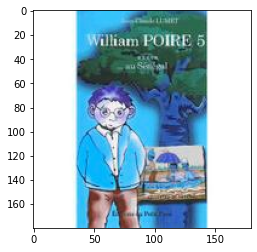

1/1 [==============================] - 0s 15ms/step
actual_class_label : Children's Book - Youth
predicted_class_label : Tourism - Travel  with probability :  12.426823377609253 %
predicted_class_label : Drawing Strip - Manga - Humor  with probability :  12.405811250209808 %
predicted_class_label : Languages - Dictionary  with probability :  8.863533288240433 %
predicted_class_label : EDUCATION  with probability :  8.073574304580688 %
************************************


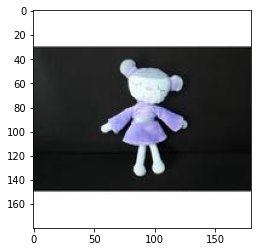

1/1 [==============================] - 0s 17ms/step
actual_class_label : First age toy
predicted_class_label : First age toy  with probability :  84.53224301338196 %
predicted_class_label : Imitation toy  with probability :  8.01631435751915 %
predicted_class_label : IMAGINATION  with probability :  2.993221767246723 %
predicted_class_label : Recre Games - Outdoor Games  with probability :  1.8100405111908913 %
************************************


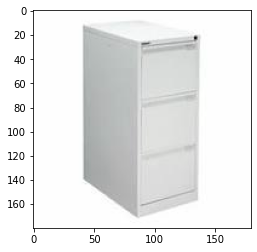

1/1 [==============================] - 0s 15ms/step
actual_class_label : OFFICE FURNITURE
predicted_class_label : Room cabinet  with probability :  38.06329369544983 %
predicted_class_label : Stay furniture - entrance  with probability :  13.081690669059753 %
predicted_class_label : Small furniture completely  with probability :  12.413018196821213 %
predicted_class_label : OFFICE FURNITURE  with probability :  9.485474973917007 %
************************************


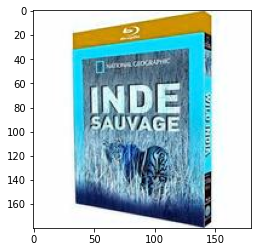

1/1 [==============================] - 0s 16ms/step
actual_class_label : Blu-raw
predicted_class_label : Blu-raw  with probability :  94.11344528198242 %
predicted_class_label : DVD  with probability :  4.663325101137161 %
predicted_class_label : VIDEO GAMES  with probability :  0.907021202147007 %
predicted_class_label : FOOD  with probability :  0.09318229858763516 %
************************************


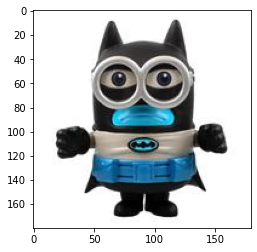

1/1 [==============================] - 0s 19ms/step
actual_class_label : Miniature world
predicted_class_label : Miniature world  with probability :  38.017138838768005 %
predicted_class_label : Poll - Plush  with probability :  17.297376692295074 %
predicted_class_label : IMAGINATION  with probability :  7.704067975282669 %
predicted_class_label : Imitation toy  with probability :  7.1396879851818085 %
************************************


In [7]:
import matplotlib.pyplot as plt
import cv2
import random
from keras.models import load_model
import numpy as np

model=load_model('VGG_16_small.hdf5')

images_ = new_small_df['image_path'].values
classes_ = new_small_df['category_level2'].values
lst=np.arange(len(images_))
ids=np.random.choice(lst, size = 5, replace = False)

for i in ids:
  image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (128, 128))
  image = np.expand_dims(image, axis=0)
  
  plt.imshow(cv2.imread(images_[i]))
  plt.show()
  
  pred = model.predict(image,verbose=1)
  
  actual_label=classes_[i]
  print('actual_class_label :',actual_label)
  
  for h in range(4):
    pred_index=np.argsort(pred[0])[-1-h]
    predicted_label=classes_list[pred_index]
    print('predicted_class_label :',predicted_label, ' with probability : ', pred[0][pred_index]*100,'%')
  
  print("************************************")

### Observations
* This is working fine and we are able to predict the probability of the images correctly, this means that the main culprit for the previous models is class imbalance.
* Now that the simple model like VGG-16 is working fine , we can now try with more complex models with full tuning.

### 5.3.3 VGG-19 by tuning all the layers

80150528/80134624 [==============================] - 184s 2us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 custom_conv1d (Conv2D)      (None, 2, 2, 1024)        4719616   
                                                                 
 custom_pool (MaxPooling2D)  (None, 1, 1, 1024)        0         
                                                                 
 custom_flat (Flatten)       (None, 1024)              0         
                                                                 
 custom_fc1 (Dense)          (None, 1024)              1049600   
                                                                 
 custom_fc2 (Dense)          (None, 512)               524800    
                                                       

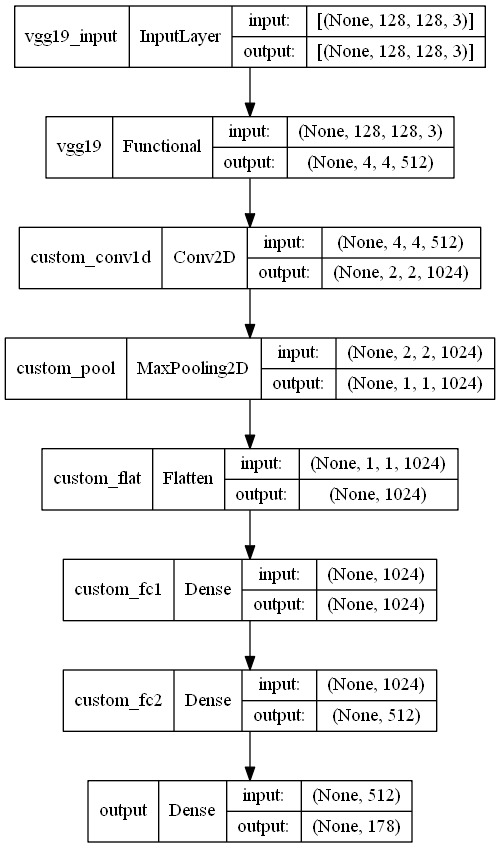

In [4]:
from tensorflow.keras import applications
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPool2D
import keras

model=Sequential()

#add the VGG-19 to the model
model.add(applications.vgg19.VGG19(weights='imagenet',include_top = False, input_shape=(128,128,3)))

#add the custom layers as mentioned above
model.add(Conv2D(kernel_size=(3,3),filters=1024,activation='relu', name='custom_conv1d'))
model.add(MaxPool2D(pool_size=(2,2),strides=(1,1), name='custom_pool'))
model.add(Flatten(name='custom_flat'))
model.add(Dense(1024, activation='relu',name='custom_fc1'))
model.add(Dense(512,activation='relu',name='custom_fc2'))
model.add(Dense(178,activation='softmax',name='output'))

model.summary()

#save the model image and plot the model
dot_img_file = 'VGG_19_small_model_full.png'
keras.utils.vis_utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,LearningRateScheduler
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

#assign the custom learning rate
def scheduler(epoch,lr):
    if epoch > 4:
        lr = 0.0005
    if epoch > 8:
        lr = 0.0001
    if epoch > 11:
        lr = 0.00005
    if epoch > 14:
        lr = 0.00001
    return lr
lr_schedule=LearningRateScheduler(scheduler)

#compile the model with required optimizer
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1), metrics=['accuracy'])

#Add the required call backs
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_accuracy",mode="auto",patience=3,verbose=1)
checkpt = ModelCheckpoint(monitor="val_accuracy",mode="auto",filepath='VGG_19_small_fully_tuned.hdf5',verbose=1,save_best_only=True)
callback_list = [earlystop,checkpt, tensorboard_callback, lr_schedule]

#give the number of train and test data points to be loaded in each batch
train_steps=train_data_generator.n//train_data_generator.batch_size
validation_steps=validation_data_generator.n//validation_data_generator.batch_size

#train the model and save the best model
model.fit_generator(train_data_generator, epochs=20, validation_data = validation_data_generator,\
                        steps_per_epoch=train_steps,validation_steps=validation_steps,callbacks=callback_list)

Epoch 1/20
10012/10012 [==============================] - ETA: 0s - loss: 4.3819 - accuracy: 0.0942
Epoch 00001: val_accuracy improved from -inf to 0.24134, saving model to VGG_19_small_fully_tuned.hdf5
10012/10012 [==============================] - 1991s 198ms/step - loss: 4.3819 - accuracy: 0.0942 - val_loss: 3.3647 - val_accuracy: 0.2413 - lr: 0.0010
Epoch 2/20
10012/10012 [==============================] - ETA: 0s - loss: 3.1221 - accuracy: 0.2856
Epoch 00002: val_accuracy improved from 0.24134 to 0.32093, saving model to VGG_19_small_fully_tuned.hdf5
10012/10012 [==============================] - 2589s 259ms/step - loss: 3.1221 - accuracy: 0.2856 - val_loss: 2.9142 - val_accuracy: 0.3209 - lr: 0.0010
Epoch 3/20
10012/10012 [==============================] - ETA: 0s - loss: 2.7591 - accuracy: 0.3532
Epoch 00003: val_accuracy improved from 0.32093 to 0.37511, saving model to VGG_19_small_fully_tuned.hdf5
10012/10012 [==============================] - 2448s 244ms/step - loss: 2.7591 

In [ ]:
%tensorboard --logdir logs/fits

* The White line --> Train score and loss <br>
* The Orange line --> Validation score and loss <br>

<img src='https://imgur.com/G8AyveE.png'>

#### Let us check the performance of the model

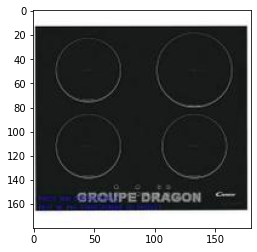

1/1 [==============================] - 3s 3s/step
actual_class_label : Baking appliances
predicted_class_label : Baking appliances  with probability :  99.97312426567078 %
predicted_class_label : Cooking appliance  with probability :  0.02270514378324151 %
predicted_class_label : Cooking food  with probability :  0.0017819151253206655 %
predicted_class_label : Amplifier - Speakers  with probability :  0.0015674828318879008 %
************************************


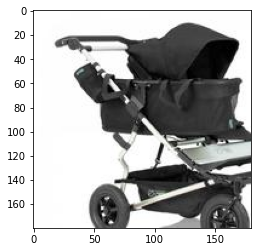

1/1 [==============================] - 0s 17ms/step
actual_class_label : Trip
predicted_class_label : Trip  with probability :  99.04171228408813 %
predicted_class_label : Luggage Storage  with probability :  0.4416785668581724 %
predicted_class_label : Poll - Plush  with probability :  0.3283127909526229 %
predicted_class_label : DRIVING HELP - SECURITY  with probability :  0.054828543215990067 %
************************************


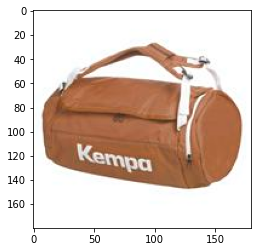

1/1 [==============================] - 0s 16ms/step
actual_class_label : Multisport
predicted_class_label : Multisport  with probability :  84.87349152565002 %
predicted_class_label : Luggage  with probability :  12.196929007768631 %
predicted_class_label : Habitat - Sleeping  with probability :  1.5601441264152527 %
predicted_class_label : Leather goods  with probability :  0.4987603984773159 %
************************************


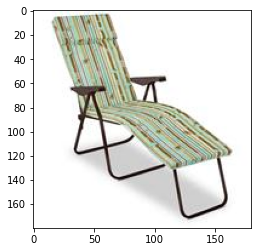

1/1 [==============================] - 0s 18ms/step
actual_class_label : Outdoor Furniture - Garden
predicted_class_label : Outdoor Furniture - Garden  with probability :  99.98955726623535 %
predicted_class_label : Siege - Assisi  with probability :  0.0047810488467803225 %
predicted_class_label : OFFICE FURNITURE  with probability :  0.0022185056877788156 %
predicted_class_label : Small furniture completely  with probability :  0.0010942860171780922 %
************************************


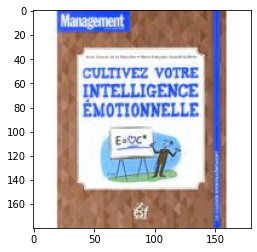

1/1 [==============================] - 0s 16ms/step
actual_class_label : Health - Wellness
predicted_class_label : Languages - Dictionary  with probability :  18.560615181922913 %
predicted_class_label : Company - Marketing - Finance  with probability :  16.214953362941742 %
predicted_class_label : Health - Wellness  with probability :  12.281138449907303 %
predicted_class_label : MEDICINE  with probability :  9.85415056347847 %
************************************


In [6]:
import matplotlib.pyplot as plt
import cv2
import random
from keras.models import load_model
import numpy as np

model=load_model('VGG_19_small_fully_tuned.hdf5')

images_ = new_small_df['image_path'].values
classes_ = new_small_df['category_level2'].values
lst=np.arange(len(images_))
ids=np.random.choice(lst, size = 5, replace = False)

for i in ids:
  image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (128, 128))
  image = np.expand_dims(image, axis=0)
  
  plt.imshow(cv2.imread(images_[i]))
  plt.show()
  
  pred = model.predict(image,verbose=1)
  
  actual_label=classes_[i]
  print('actual_class_label :',actual_label)
  
  for h in range(4):
    pred_index=np.argsort(pred[0])[-1-h]
    predicted_label=classes_list[pred_index]
    print('predicted_class_label :',predicted_label, ' with probability : ', pred[0][pred_index]*100,'%')
  
  print("************************************")

### 5.3.4 Resnet50 by tuning all layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 custom_conv2d (Conv2D)      (None, 4, 4, 512)         1049088   
                                                                 
 custom_flat (Flatten)       (None, 8192)              0         
                                                                 
 custom_FC (Dense)           (None, 640)               5243520   
                                                                 
 output_layer (Dense)        (None, 178)               114098    
                                                                 
Total params: 29,994,418
Trainable params: 29,941,298
Non-trainable params: 53,120
_________________________________________________________________


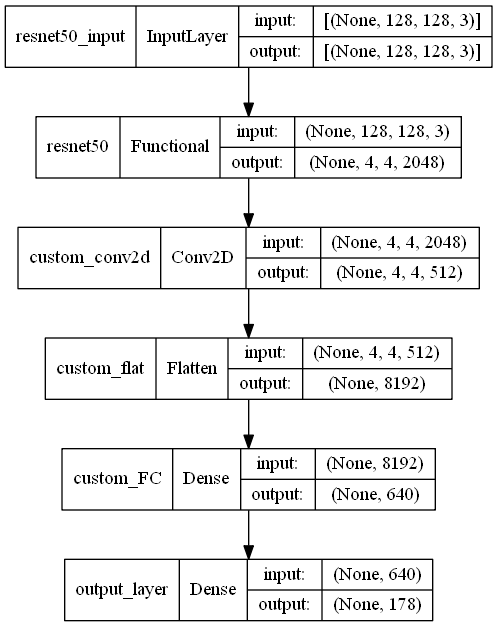

In [4]:
from tensorflow.keras import applications
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPool2D
import keras

model=Sequential()
#get the resnet50 with pretrained weights
resnet_model=applications.resnet.ResNet50(weights='imagenet',include_top = False, input_shape=(128,128,3))
model.add(resnet_model)
#add a custom convolutional layer
model.add(Conv2D(kernel_size=(1,1),filters=512,activation='relu', name='custom_conv2d'))
#flatten the output from the convolutional layer
model.add(Flatten(name='custom_flat'))
#add a fully connected layer
model.add(Dense(640,activation='relu',name='custom_FC'))
#add an output layer with softmax
model.add(Dense(178, activation='softmax', name='output_layer'))
#make the model as shown below
model.summary()

#plot the final architecture of the model
dot_img_file = 'resnet50_fully_tuned.png'
keras.utils.vis_utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,LearningRateScheduler
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

#assign the custom learning rate
def scheduler(epoch,lr):
    if epoch > 7:
        lr = 0.0001
    if epoch > 9:
        lr = 0.00005
    if epoch > 11:
        lr = 0.00001
    return lr
lr_schedule=LearningRateScheduler(scheduler)

#compile the model with required optimizer
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003,epsilon=0.1),metrics=['accuracy'])

#Add the required call backs
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_accuracy",verbose=1,mode="auto",patience=4)
checkpt = ModelCheckpoint(monitor="val_accuracy",mode="auto",verbose=1,filepath='resnet50_fully_tuned.hdf5',save_best_only=True)
callback_list = [earlystop,checkpt,tensorboard_callback,lr_schedule]

#give the number of train and test data points to be loaded in each batch
train_steps=train_data_generator.n//train_data_generator.batch_size
validation_steps=validation_data_generator.n//validation_data_generator.batch_size

#train the model and save the best model
model.fit_generator(train_data_generator, epochs=20, validation_data = validation_data_generator,\
                        steps_per_epoch=train_steps,validation_steps=validation_steps,callbacks=callback_list)

Epoch 1/20
10012/10012 [==============================] - ETA: 0s - loss: 3.7946 - accuracy: 0.1774
Epoch 00001: val_accuracy improved from -inf to 0.27198, saving model to resnet50_fully_tuned.hdf5
10012/10012 [==============================] - 1296s 129ms/step - loss: 3.7946 - accuracy: 0.1774 - val_loss: 3.2215 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 2/20
10012/10012 [==============================] - ETA: 0s - loss: 3.0968 - accuracy: 0.2949
Epoch 00002: val_accuracy improved from 0.27198 to 0.33807, saving model to resnet50_fully_tuned.hdf5
10012/10012 [==============================] - 1523s 152ms/step - loss: 3.0968 - accuracy: 0.2949 - val_loss: 2.8838 - val_accuracy: 0.3381 - lr: 3.0000e-04
Epoch 3/20
10012/10012 [==============================] - ETA: 0s - loss: 2.7554 - accuracy: 0.3599
Epoch 00003: val_accuracy improved from 0.33807 to 0.37832, saving model to resnet50_fully_tuned.hdf5
10012/10012 [==============================] - 1758s 176ms/step - loss: 2.7554 - ac

In [ ]:
%tensorboard --logdir logs/fits

* The Red line --> Train score and loss <br>
* The Blue line --> Validation score and loss <br>

<img src='https://imgur.com/Uc9EoHX.png'>

#### Let us check the performance of the model

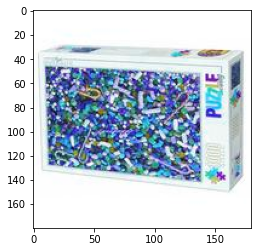

1/1 [==============================] - 0s 30ms/step
actual_class_label : GAMES OF COMPANY
predicted_class_label : GAMES OF COMPANY  with probability :  34.84772741794586 %
predicted_class_label : LITTLE FURNITURE  with probability :  13.959690928459167 %
predicted_class_label : Multisport  with probability :  5.151307582855225 %
predicted_class_label : CHRISTMAS DECORATION  with probability :  3.6644916981458664 %
************************************


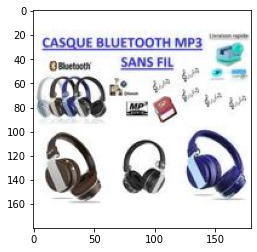

1/1 [==============================] - 0s 26ms/step
actual_class_label : Headphones - Microphone - Dictaphone
predicted_class_label : Headphones - Microphone - Dictaphone  with probability :  57.36985802650452 %
predicted_class_label : PC periphery  with probability :  22.142210602760315 %
predicted_class_label : SECURITY HOUSE  with probability :  6.952034682035446 %
predicted_class_label : Console Accessories - Games  with probability :  4.022510722279549 %
************************************


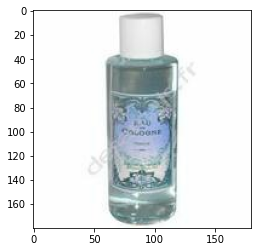

1/1 [==============================] - 0s 28ms/step
actual_class_label : PERFUME
predicted_class_label : PERFUME  with probability :  89.51326608657837 %
predicted_class_label : Candlestick - Photophore - Candle - Scent  with probability :  2.7778731659054756 %
predicted_class_label : Body and face  with probability :  2.7461256831884384 %
predicted_class_label : Self-Service Treatments - Care Pathologies  with probability :  1.7036983743309975 %
************************************


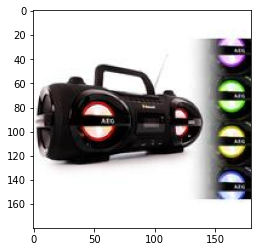

1/1 [==============================] - 0s 30ms/step
actual_class_label : Music player
predicted_class_label : Music player  with probability :  72.17124104499817 %
predicted_class_label : DRONE  with probability :  11.774206906557083 %
predicted_class_label : Console Accessories - Games  with probability :  5.4213788360357285 %
predicted_class_label : Audio  with probability :  3.2839540392160416 %
************************************


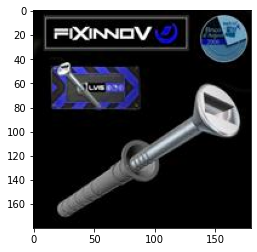

1/1 [==============================] - 0s 36ms/step
actual_class_label : HARDWARE STORE
predicted_class_label : HARDWARE STORE  with probability :  25.03199875354767 %
predicted_class_label : Piercing jewel  with probability :  9.753260761499405 %
predicted_class_label : DRONE  with probability :  9.632810950279236 %
predicted_class_label : COOKING TOOLS  with probability :  8.635898679494858 %
************************************


In [5]:
import matplotlib.pyplot as plt
import cv2
import random
from keras.models import load_model
import numpy as np

model=load_model('resnet50_fully_tuned.hdf5')

images_ = new_small_df['image_path'].values
classes_ = new_small_df['category_level2'].values
lst=np.arange(len(images_))
ids=np.random.choice(lst, size = 5, replace = False)

for i in ids:
  image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (128, 128))
  image = np.expand_dims(image, axis=0)
  
  plt.imshow(cv2.imread(images_[i]))
  plt.show()
  
  pred = model.predict(image,verbose=1)
  
  actual_label=classes_[i]
  print('actual_class_label :',actual_label)
  
  for h in range(4):
    pred_index=np.argsort(pred[0])[-1-h]
    predicted_label=classes_list[pred_index]
    print('predicted_class_label :',predicted_label, ' with probability : ', pred[0][pred_index]*100,'%')
  
  print("************************************")

### 5.3.5 Inceptionet V3

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 custom_flat (Flatten)       (None, 8192)              0         
                                                                 
 custom_fc1 (Dense)          (None, 1024)              8389632   
                                                                 
 custom_fc2 (Dense)          (None, 512)               524800    
                                                                 
 output (Dense)              (None, 178)               91314     
                                                                 
Total params: 30,808,530
Trainable params: 30,774,098
Non-trainable params: 34,432
_________________________________________________________________


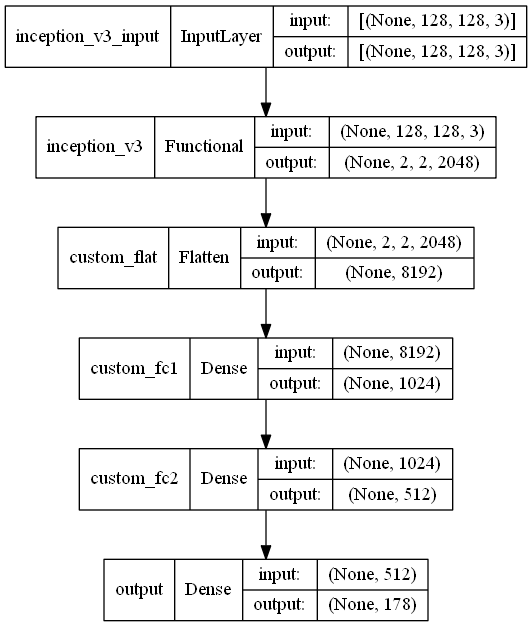

In [5]:
from tensorflow.keras import applications
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPool2D
import keras

model=Sequential()

#add the VGG-16 to the model
model.add(applications.inception_v3.InceptionV3(weights='imagenet',include_top = False, input_shape=(128,128,3)))

#add the custom layers as mentioned above
#model.add(Conv2D(kernel_size=(3,3),filters=1024,activation='relu', name='custom_conv1d'))
#model.add(MaxPool2D(pool_size=(2,2),strides=(1,1), name='custom_pool'))
model.add(Flatten(name='custom_flat'))
model.add(Dense(1024, activation='relu',name='custom_fc1'))
model.add(Dense(512,activation='relu',name='custom_fc2'))
model.add(Dense(178,activation='softmax',name='output'))

model.summary()

#save the model image and plot the model
dot_img_file = 'Inception_V3_tuned.png'
keras.utils.vis_utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,LearningRateScheduler
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

#assign the custom learning rate
def scheduler(epoch,lr):
    if epoch > 4:
        lr = 0.0005
    if epoch > 8:
        lr = 0.0001
    if epoch > 11:
        lr = 0.00005
    if epoch > 14:
        lr = 0.00001
    return lr
lr_schedule=LearningRateScheduler(scheduler)

#compile the model with required optimizer
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1), metrics=['accuracy'])

#Add the required call backs
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_accuracy",mode="auto",patience=4,verbose=1)
checkpt = ModelCheckpoint(monitor="val_accuracy",mode="auto",filepath='Inception_V3_fully_tuned.hdf5',verbose=1,save_best_only=True)
callback_list = [earlystop,checkpt, tensorboard_callback, lr_schedule]

#give the number of train and test data points to be loaded in each batch
train_steps=train_data_generator.n//train_data_generator.batch_size
validation_steps=validation_data_generator.n//validation_data_generator.batch_size

#train the model and save the best model
model.fit_generator(train_data_generator, epochs=20, validation_data = validation_data_generator,\
                        steps_per_epoch=train_steps,validation_steps=validation_steps,callbacks=callback_list)

Epoch 1/20
10012/10012 [==============================] - ETA: 0s - loss: 3.7440 - accuracy: 0.1885
Epoch 00001: val_accuracy improved from -inf to 0.31020, saving model to Inception_V3_fully_tuned.hdf5
10012/10012 [==============================] - 1186s 117ms/step - loss: 3.7440 - accuracy: 0.1885 - val_loss: 3.0552 - val_accuracy: 0.3102 - lr: 0.0010
Epoch 2/20
10012/10012 [==============================] - ETA: 0s - loss: 2.9628 - accuracy: 0.3177
Epoch 00002: val_accuracy improved from 0.31020 to 0.36443, saving model to Inception_V3_fully_tuned.hdf5
10012/10012 [==============================] - 1388s 139ms/step - loss: 2.9628 - accuracy: 0.3177 - val_loss: 2.7915 - val_accuracy: 0.3644 - lr: 0.0010
Epoch 3/20
10012/10012 [==============================] - ETA: 0s - loss: 2.7022 - accuracy: 0.3657
Epoch 00003: val_accuracy improved from 0.36443 to 0.40136, saving model to Inception_V3_fully_tuned.hdf5
10012/10012 [==============================] - 1465s 146ms/step - loss: 2.7022 

In [ ]:
%tensorboard --logdir logs/fits

* The Red line --> Train score and loss <br>
* The Green line --> Validation score and loss <br>

<img src='https://imgur.com/tKC0eJI.png'>

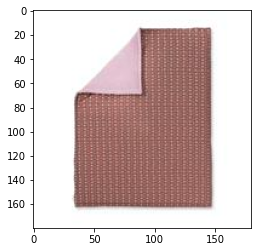

1/1 [==============================] - 0s 30ms/step
actual_class_label : Baby sleep
predicted_class_label : BEDDING  with probability :  65.6454086303711 %
predicted_class_label : Baby sleep  with probability :  16.25639796257019 %
predicted_class_label : Paper - notebook - notebook  with probability :  6.696424633264542 %
predicted_class_label : Table linen - Kitchen  with probability :  6.596760451793671 %
************************************


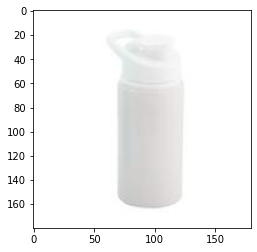

1/1 [==============================] - 0s 29ms/step
actual_class_label : Multisport
predicted_class_label : Multisport  with probability :  95.87647914886475 %
predicted_class_label : Candlestick - Photophore - Candle - Scent  with probability :  1.1174577288329601 %
predicted_class_label : Food preservation  with probability :  1.0691041126847267 %
predicted_class_label : Vase - Cut - Flower  with probability :  0.6226446945220232 %
************************************


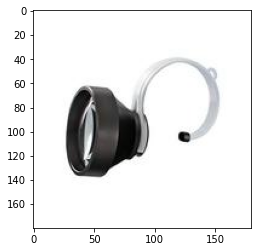

1/1 [==============================] - 0s 32ms/step
actual_class_label : Objective - Flash - Zoom
predicted_class_label : Objective - Flash - Zoom  with probability :  69.21855211257935 %
predicted_class_label : Headphones - Microphone - Dictaphone  with probability :  16.759678721427917 %
predicted_class_label : PC periphery  with probability :  9.435081481933594 %
predicted_class_label : Amplifier - Speakers  with probability :  2.48742438852787 %
************************************


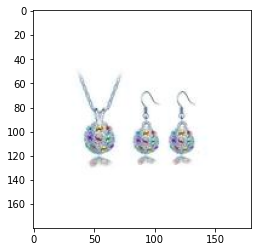

1/1 [==============================] - 0s 37ms/step
actual_class_label : JEWELRY
predicted_class_label : JEWELRY  with probability :  82.5973391532898 %
predicted_class_label : Piercing jewel  with probability :  4.777930676937103 %
predicted_class_label : Pearl - Jewelry - Badge  with probability :  2.9287079349160194 %
predicted_class_label : Baby sleep  with probability :  1.6925856471061707 %
************************************


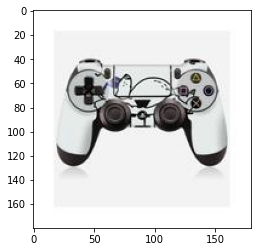

1/1 [==============================] - 0s 30ms/step
actual_class_label : Console Accessories - Games
predicted_class_label : Console Accessories - Games  with probability :  98.70562553405762 %
predicted_class_label : Keyboard - Mouse - Webcam  with probability :  1.184912584722042 %
predicted_class_label : DRONE  with probability :  0.014031733735464513 %
predicted_class_label : Recre Games - Outdoor Games  with probability :  0.013197693624533713 %
************************************


In [14]:
import matplotlib.pyplot as plt
import cv2
import random
from keras.models import load_model
import numpy as np

model=load_model('Inception_V3_fully_tuned.hdf5')

images_ = new_small_df['image_path'].values
classes_ = new_small_df['category_level2'].values
lst=np.arange(len(images_))
ids=np.random.choice(lst, size = 5, replace = False)

for i in ids:
  image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (128, 128))
  image = np.expand_dims(image, axis=0)
  
  plt.imshow(cv2.imread(images_[i]))
  plt.show()
  
  pred = model.predict(image,verbose=1)
  
  actual_label=classes_[i]
  print('actual_class_label :',actual_label)
  
  for h in range(4):
    pred_index=np.argsort(pred[0])[-1-h]
    predicted_label=classes_list[pred_index]
    print('predicted_class_label :',predicted_label, ' with probability : ', pred[0][pred_index]*100,'%')
  
  print("************************************")
  

# 6. Summary

In [33]:
from prettytable import PrettyTable

x= PrettyTable()
x.field_names=['S.NO','Models','Type of data','number of classes','Accuracy']
x.add_row([1,'Baseline model','on 100K images','5070 of class level 3','44.82%'])
x.add_row([2,'Baseline model with class weights','on 100K images','5070 of class level 3','0 %'])
x.add_row([3,'resnet50 with fine tuning of last layers','on 100K images','5070 of class level 3','26.02 %'])
x.add_row([4,'resnet50 with fine tuning all layers','on 100K images','5070 of class level 3','54.90 %'])
x.add_row(['----','-------------------------------------------','------------------------------------------','----------------','--------'])
x.add_row([5,'VGG-16 with fine tuning of last layers','on 10K images with image augmentations','178 of class level 2','25.66 %'])
x.add_row([6,'VGG-16 with fine tuning of all layers','on 10K images with image augmentations','178 of class level 2','49.281 %'])
x.add_row([7,'VGG-19 with fine tuning of all layers','on 10K images with image augmentations','178 of class level 2','50.214 %'])
x.add_row([8,'resnet50 with fine tuning of all layers','on 10K images with image augmentations','178 of class level 2','49.674 %'])
x.add_row([9,'Inceptionet_V3 with fine tuning of all layers','on 10K images with image augmentations','178 of class level 2','50.691 %'])

print(x)

+------+-----------------------------------------------+--------------------------------------------+-----------------------+----------+
| S.NO |                     Models                    |                Type of data                |   number of classes   | Accuracy |
+------+-----------------------------------------------+--------------------------------------------+-----------------------+----------+
|  1   |                 Baseline model                |               on 100K images               | 5070 of class level 3 |  44.82%  |
|  2   |       Baseline model with class weights       |               on 100K images               | 5070 of class level 3 |   0 %    |
|  3   |    resnet50 with fine tuning of last layers   |               on 100K images               | 5070 of class level 3 | 26.02 %  |
|  4   |      resnet50 with fine tuning all layers     |               on 100K images               | 5070 of class level 3 | 54.90 %  |
| ---- |  -------------------------------

# 7. Observations 

* Here we have seen that the maximum validation accuracy platues around 50% irrespective of the network, so there is chance of improvement if we take more data with class balancing.
* Here we have seen that score improved with the help of image augmentation along with class balancing.
* The performance of the models are also checked for interpretation with probability scores for the possible classes the scores make sense for the models which are trained with balanced classes.
* Fine tuning all the layers instead of last few has led to better performance of the models.